# Step 0: Make mask for bottom boundary layer from `av.h` data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
end_time = 2900  # choose from 2end_times = [2500, 2600, 2700, 2800, 2900]
bbl_thickness = 5 # define bottom boundary layer thickness, consistent with what model uses

In [3]:
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
run = 'nw2_0.03125deg_N15_baseline_hmix20'
chunks = {'time': 1, 'zl':1}
nr_days = 100

st = xr.open_dataset('%s/%s/static.nc' % (path,run), decode_times=False)
av = xr.open_dataset('%s/%s/averages_%08d.nc' % (path, run, end_time-nr_days+2), decode_times=False, chunks=chunks)

## Prepare NW2 grid information

In [4]:
from xgcm import Grid

Nx = np.size(st.xh)
Ny = np.size(st.yh)
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'},
            'Z': {'center': 'zl', 'outer': 'zi'} }


grid = Grid(st, coords=coords, periodic=['X'])

## Time-dependent mask for bottom layers

In [5]:
ds = xr.Dataset()  # new xarray dataset for bottom mask
ds.attrs['bottom boundary layer thickness'] = bbl_thickness

Goal: Make `ds.bottom_mask` which is
* = 1 if the lower interface of layer n is within the bottom boundary layer,
* = 0 otherwise

In [6]:
# look for minimum amount of layers from bottom that sum up to more than bbl_thickness
h_rev = av['h'].isel(zl=slice(None, None, -1))
eta = grid.cumsum(h_rev, 'Z', boundary='fill')
eta = eta.isel(zi=slice(None, None, -1))
mask = xr.where(eta>bbl_thickness, 1, 0)  # we now have a mask for interfaces
# next: transform this mask to a mask for layers
mask_interp = grid.interp(mask, 'Z')
mask_bottom = xr.where(mask_interp < 1, 1, 0)
ds['bottom_mask'] = mask_bottom
ds['bottom_mask'].attrs = {'units' : '', 'long_name': 'Bottom mask: = 1 if lower interface of layer is within BBL, = 0 otherwise'}

## Some plots

In [7]:
# Compute interface height
h_rev = av.h.isel(zl=slice(None,None,-1))
eta = grid.cumsum(h_rev,'Z',boundary='fill')
eta = eta.isel(zi=slice(None,None,-1))
eta = eta - st.depth_ocean
eta = eta.chunk({'zi':16})
eta = xr.where(st.wet,eta,np.nan)
av['eta'] = eta.transpose('time', 'zi', 'yh', 'xh') # reorder coordinates

In [8]:
time = -1

mask = ds.bottom_mask.isel(time=time).compute()
eta = av.eta.isel(time=time).compute()
eta_x = grid.interp(eta, 'X')
eta_y = grid.interp(eta, 'Y', boundary='fill')

### Zonal sections

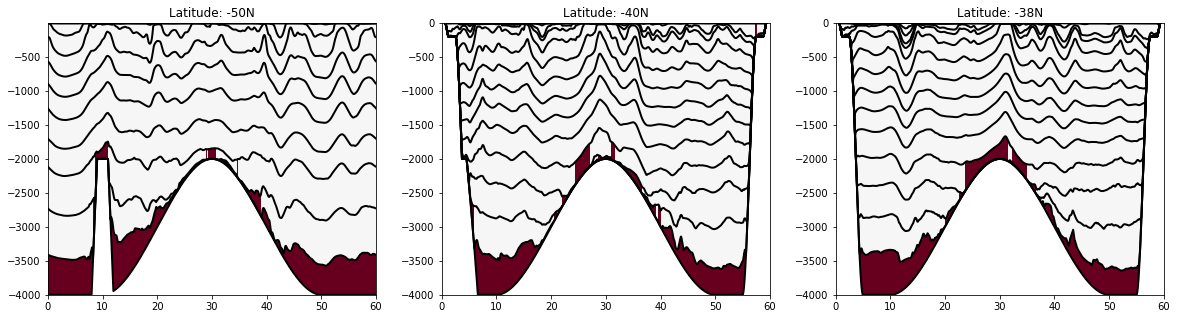

In [9]:
yhlist = [-50, -40, -38]
vmax = 1
fig, axs = plt.subplots(1,3,figsize=(20,5))
for yh, ax in zip(yhlist, axs):
    for i in range(16):
        ax.plot(st.xh, eta.isel(zi=i).sel(yh=yh, method="nearest"), linewidth=2, color='k')
    p = ax.pcolormesh(st.xq, eta_x.fillna(value=0).sel(yh=yh, method="nearest"), mask.sel(yh=yh, method="nearest"),
                        vmax=vmax, vmin=-vmax, cmap='RdBu_r')
    ax.set_title('Latitude: %iN' %yh)

### Meridional sections

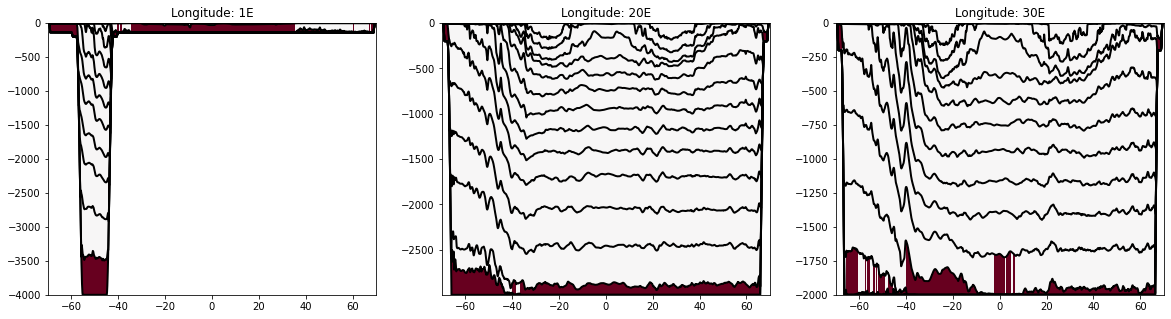

In [10]:
xhlist = [1, 20, 30]
vmax = 1

fig,axs = plt.subplots(1,3,figsize=(20,5))
for xh, ax in zip(xhlist, axs.flatten()):
    for i in range(16):
        ax.plot(ds.yh, eta.isel(zi=i).sel(xh=xh, method="nearest"), linewidth=2, color='k')
    p = ax.pcolormesh(st.yq, eta_y.fillna(value=0).sel(xh=xh, method="nearest"), mask.sel(xh=xh, method="nearest"),
                         vmax=vmax, vmin=-vmax, cmap='RdBu_r')
    ax.set_title('Longitude: %iE' %xh)

In [11]:
scratchpath = '/glade/scratch/noraloose/'
filename = '%s/%s/averages_%08d_bottom_mask.nc' %(scratchpath, run, end_time-nr_days+2)
filename

'/glade/scratch/noraloose//nw2_0.03125deg_N15_baseline_hmix20/averages_00002802_bottom_mask.nc'

In [ ]:
ds.to_netcdf(filename) 